# Trenowanie konwolucyjnej sieci neuronowej na zbiorze danych FashionMNIST
 

Ten notatnik pokazuje jak wytrenować prostą sieć CNN na zbiorze danych FashionMNIST

Importujemy potrzebne biblioteki i tworzymy transformator który zamienia obrazek na pytorchowy tensor i standaryzuje wartości. Następnie pobieramy zbiór FashionMNIST podzielony na część trenującą i testującą oraz konwertujemy go przy użyciu wcześniej zdefiniowanego transformatora. Potem tworzymy obiekt ładowacza który będzie podawał dane do sieci.

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Tworzymy prostą sieć konwolucyjną z dwoma warstwami filtrowania:
- pierwsza z 32 filtrami o rozmiarze 3x3 które rozpoznają podstawowe, lokalne wzorce w przestrzeni obrazków. Na tą warstwę nakładamy funkcję Rectified Linear Unit (ReLU) aby dodać nieliniowość do modelu.
- druga z 64 filtrami o rozmiarze 3x3 które uczą się zależności pomiędzy wcześniejszymi podstawowymi wzorcami. Na tą warstwę również nakładamy funkcję Rectified Linear Unit (ReLU) aby dodać nieliniowość do modelu.
#### Następnie dodajemy dwuwarstwową sieć neutonową:
- pierwszą warstwę z 64 neuronami oraz ReLU
- drugą warstwę jako warstwę wyjściową z aktywacją softmax. Warstwa wyjściowa podaje wektor zawierający prawdopodobieństwo przynależności inputu do jednej z 10 klas które zostały stworzone w zbiorze FashionMNIST:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

Tworzymy klasę modelu na bazie modułu torch.nn. Konstruktor definiuje warstwy modelu. Metoda forward w Module nn.Module definiuje sposób przekazywania danych w przód w grafie sieci konwolucyjnej

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Pierwsza warstwa konwolucyjna z 32 filtrami o rozmiarze 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Warstwa max-pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Druga warstwa konwolucyjna z 64 filtrami o rozmiarze 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # Pierwsza warstwa fully connected (dense) z 64 neuronami
        self.fc1 = nn.Linear(64 * 6 * 6, 64)
        # Warstwa wyjściowa z 10 neuronami dla 10 klas i aktywacją softmax
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Pierwsza warstwa konwolucyjna, max-pooling i aktywacja ReLU
        x = self.pool(F.relu(self.conv1(x)))
        # Druga warstwa konwolucyjna, max-pooling i aktywacja ReLU
        x = self.pool(F.relu(self.conv2(x)))
        # Wypłaszczenie do wektora jednowymiarowego
        x = x.view(-1, 64 * 6 * 6)
        # Pierwsza warstwa dense z aktywacją ReLU
        x = F.relu(self.fc1(x))
        # Warstwa wyjściowa z aktywacją softmax
        x = F.softmax(self.fc2(x), dim=1)
        return x

Następnie inicjalizujemy obiekt i wybieramy funkcję straty. W tym przypadku cross-entropy loss jest naszą funkcją i została wybrana ponieważ jest jedną z popularnych funkcji strat. Korzystamy z algorytmu Adam do optymalizacji. Ponownie jest to jeden z popularnych algorytmów. Tworzymy pętlę treningową z 10 wsadami

In [5]:
# Zainicjuj model, funkcję straty oraz optymalizator
model = SimpleCNN()
# Użyj cross-entropy loss jako funkcji straty
criterion = nn.CrossEntropyLoss()
# Użyj algorytmu Adam do optymalizacji
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Pętla treningowa
num_epochs = 10
for epoch in range(num_epochs):
    print("epoch {0} entered".format(epoch))
    for images, labels in train_loader:
        optimizer.zero_grad()
        # Przód: oblicz predykcje
        outputs = model(images)
        # Oblicz wartość funkcji straty
        loss = criterion(outputs, labels)
        # Wstecz: oblicz gradienty
        loss.backward()
        # Aktualizacja wag w modelu
        optimizer.step()


epoch 0 entered
epoch 1 entered
epoch 2 entered
epoch 3 entered
epoch 4 entered
epoch 5 entered
epoch 6 entered
epoch 7 entered
epoch 8 entered
epoch 9 entered


Na końcu oceniamy dokładność na zbiorze testowym. 

In [17]:
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Przód: oblicz predykcje
        outputs = model(images)
        # Wybierz indeks o najwyższym prawdopodobieństwie
        _, predicted = torch.max(outputs.data, 1)
        # Aktualizacja statystyk dla dokładności
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # zbierz predykcje oraz etykiety w celu narysowania wykresów prc oraz roc
        all_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Liczymy precyzję oraz pełność i rysujemy wykres precyzji od pełności.

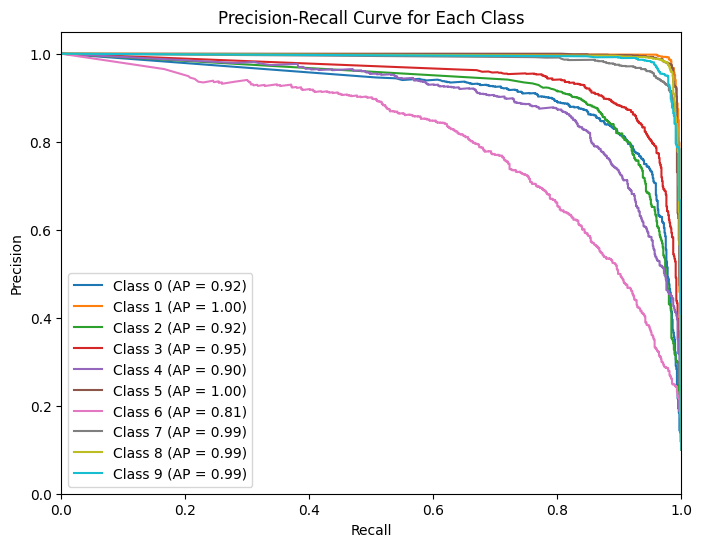

In [18]:
all_predictions = np.array(all_predictions)

# oblicz krzywą precyzji od pełności dla każdej klasy
precision = dict()
recall = dict()
average_precision = dict()

for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve((np.array(all_labels) == i).astype(int), all_predictions[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# rysuj krzywe
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.title('Precision-Recall Curve for Each Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower left')
plt.show()

Rysujemy wykres ROC (charakterystyka robocza odbiornika) oraz obszar pod krzywą (AUC)

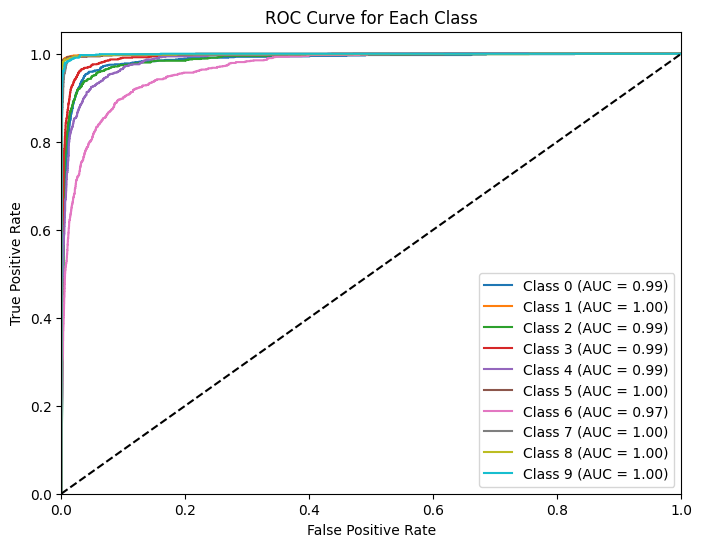

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1],'k--') #przekątna dla modelu losowego
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()